## Model Evaluation

Fitting models to data after performing feature selection

In [37]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import xgboost as xgb
import warnings
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator
import itertools

Helper functions for evaluation and plotting

In [38]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

In [39]:
filepath = "../data/T2D_data/FeatureSelected/chi2/"

X_train = pd.read_csv(filepath + "X_train.csv", index_col=0)
y_train = pd.read_csv(filepath + "y_train.csv", index_col=0, header=None)
X_test = pd.read_csv(filepath + "X_test.csv", index_col=0)
y_test = pd.read_csv(filepath + "y_test.csv", index_col=0, header=None)

In [40]:
n_drop = 300
X_train = X_train.iloc[:-n_drop, :]
y_train = y_train.iloc[:-n_drop, :]
X_test = X_test.iloc[:-n_drop, :]
y_test = y_test.iloc[:-n_drop, :]


In [41]:
X_train.head()

,Ishikawa_ChIP-seq_YY1_ENCSR000BSY_ENCFF001TVY_ENCFF001TVX_intersect.bed,HepG2_ChIP-seq_MAX_ENCSR000BTM_ENCFF001UGM_ENCFF001UGN_intersect.bed,H1-hESC_ChIP-seq_BACH1_ENCFF002CQP.bed,H1-hESC_ChIP-seq_MAX_ENCFF002CRA.bed,E004-H3K79me1.gappedPeak,E004-H3K79me2.gappedPeak,E008-H3K79me2.gappedPeak,E087-H3K27ac.gappedPeak,E118-H3K79me2.gappedPeak,E122-H4K20me1.gappedPeak,...,PDX1,GSE64233_p65_V_final.bed,GSM1208731_batch2_chrom1_LoVo_E2F8_PassedQC_peaks_hg19.bed,GSM1208739_batch2_chrom1_LoVo_ETV7_PassedQC_peaks_hg19.bed,GSM1208788_batch2_chrom1_LoVo_RARG_PassedQC_peaks_hg19.bed,pancreas_adult_H3K27ac.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,1,1,0,36
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [42]:
# # Add sample weights based on prevalence of class
# sample_weight = [1.1 if sample == 1 else 0 for sample in y_train.iloc[:, 0] ]

# Normalize the snpcount column which is continuous, to fall between 0 and 1
X_train['snpcount'] = (X_train['snpcount'] - X_train['snpcount'].min()) / (X_train['snpcount'].max() - X_train['snpcount'].min())
X_test['snpcount'] = (X_test['snpcount'] - X_test['snpcount'].min()) / (X_test['snpcount'].max() - X_test['snpcount'].min())

In [43]:
X_train.head()

,Ishikawa_ChIP-seq_YY1_ENCSR000BSY_ENCFF001TVY_ENCFF001TVX_intersect.bed,HepG2_ChIP-seq_MAX_ENCSR000BTM_ENCFF001UGM_ENCFF001UGN_intersect.bed,H1-hESC_ChIP-seq_BACH1_ENCFF002CQP.bed,H1-hESC_ChIP-seq_MAX_ENCFF002CRA.bed,E004-H3K79me1.gappedPeak,E004-H3K79me2.gappedPeak,E008-H3K79me2.gappedPeak,E087-H3K27ac.gappedPeak,E118-H3K79me2.gappedPeak,E122-H4K20me1.gappedPeak,...,PDX1,GSE64233_p65_V_final.bed,GSM1208731_batch2_chrom1_LoVo_E2F8_PassedQC_peaks_hg19.bed,GSM1208739_batch2_chrom1_LoVo_ETV7_PassedQC_peaks_hg19.bed,GSM1208788_batch2_chrom1_LoVo_RARG_PassedQC_peaks_hg19.bed,pancreas_adult_H3K27ac.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.013831
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.005533
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,1,1,0,0.048409
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.001383


### Logistic Regression

In [44]:
log_model = LogisticRegressionCV(solver='lbfgs', 
                                 penalty='l2', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000,
                                 n_jobs=-1)

log_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

In [45]:
print("Training Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_train, y_train, threshold=0.5)

Training Dataset Logistic Model Performance:
 Precision: 0.2875
 Recall: 0.5313531353135313
 Accuracy: 0.7029104887424492


In [46]:
print("Test Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_test, y_test, threshold=0.5)

Test Dataset Logistic Model Performance:
 Precision: 0.35864978902953587
 Recall: 0.5592105263157895
 Accuracy: 0.7133507853403142


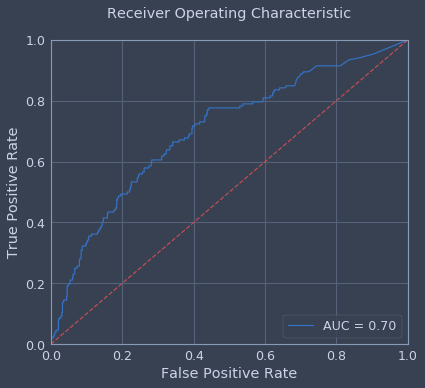

In [47]:
ev.plot_roc_curve(log_model, X_test, y_test)

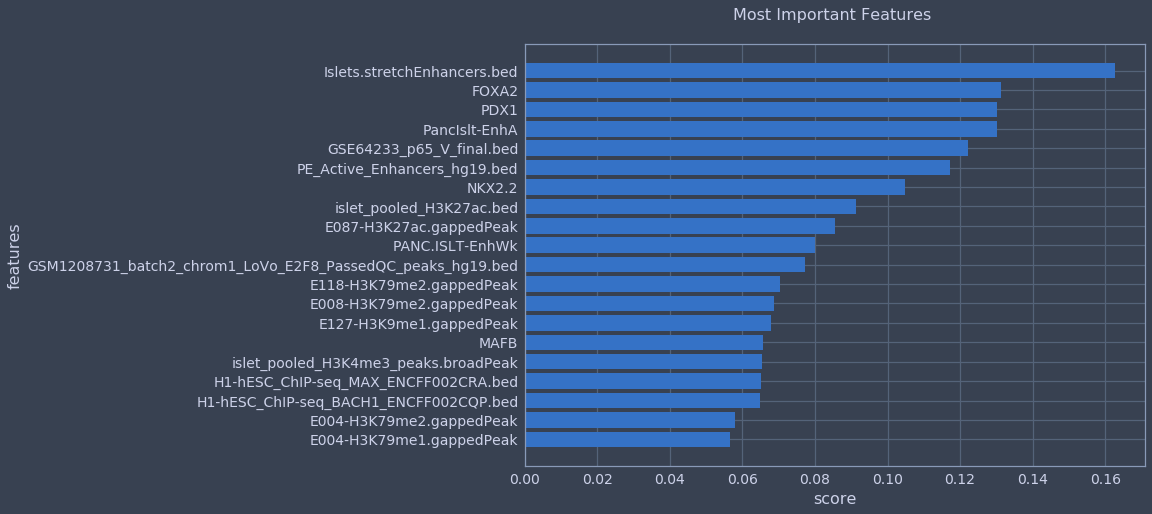

In [48]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)[0]

In [49]:
#  ev.recursive_elim(log_model, X_train, y_train, step=10, cv=None)

### Support Vector Machine 

In [50]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=5000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [51]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_train, y_train, proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.33260393873085337
 Recall: 0.5016501650165016
 Accuracy: 0.7495881383855024


In [52]:
print("Test Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_test, y_test, threshold=0.5)

Test Dataset SVM Model Performance:
 Precision: 1.0
 Recall: 0.019736842105263157
 Accuracy: 0.8049738219895288


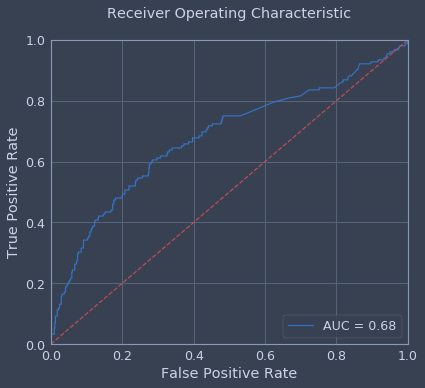

In [53]:
ev.plot_roc_curve(svm_model, X_test, y_test)

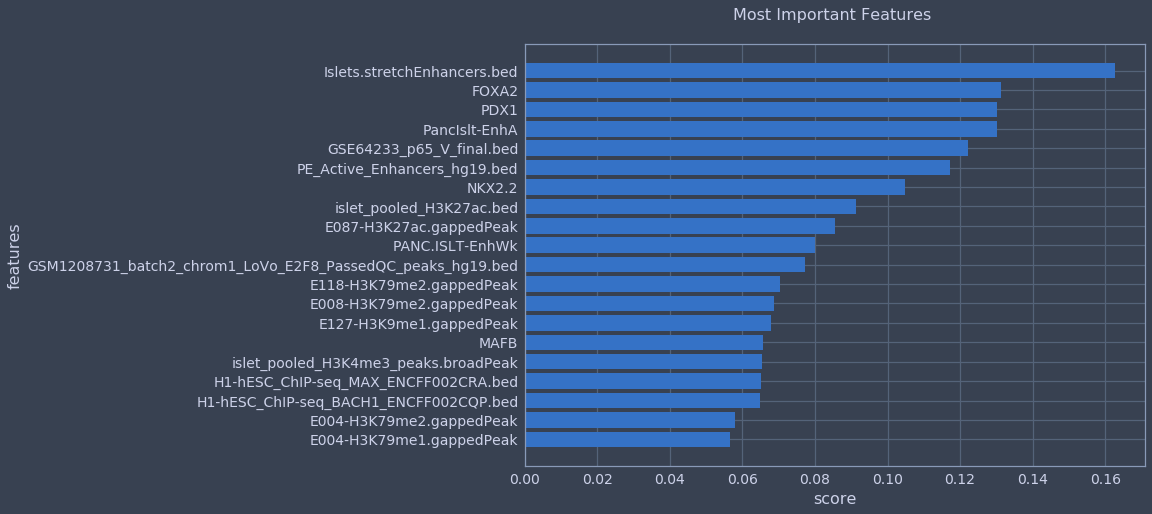

In [55]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)

### Random Forest

In [22]:
X_train = X_train.drop(['snpcount'], axis=1)
X_test = X_test.drop(['snpcount'], axis=1)

In [23]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

# Parameter grid for grid search
rf_params = {'n_estimators': [100, 500, 1000, 2000],
			 'max_depth': [30, 100, 200]}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [24]:
# Grid search to iteratively search parameter space
rf_grid = GridSearchCV(rf_model, param_grid=rf_params, cv=cv, scoring=scoring, refit='roc_auc')
rf_grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

The best parameters are {'max_depth': 200, 'n_estimators': 100} with a score of 0.50
Grid search's score on new test data was 0.5450427054478302


In [25]:
ev.summarize_performance(rf_grid, X_train, y_train, proba=False)

Model Performance:
 Precision: 0.88
 Recall: 0.7260726072607261
 Accuracy: 0.9467232437529467


In [26]:
ev.summarize_performance(rf_grid, X_test, y_test, proba=True)

Model Performance:
 Precision: 0.24528301886792453
 Recall: 0.08552631578947369
 Accuracy: 0.831766917293233


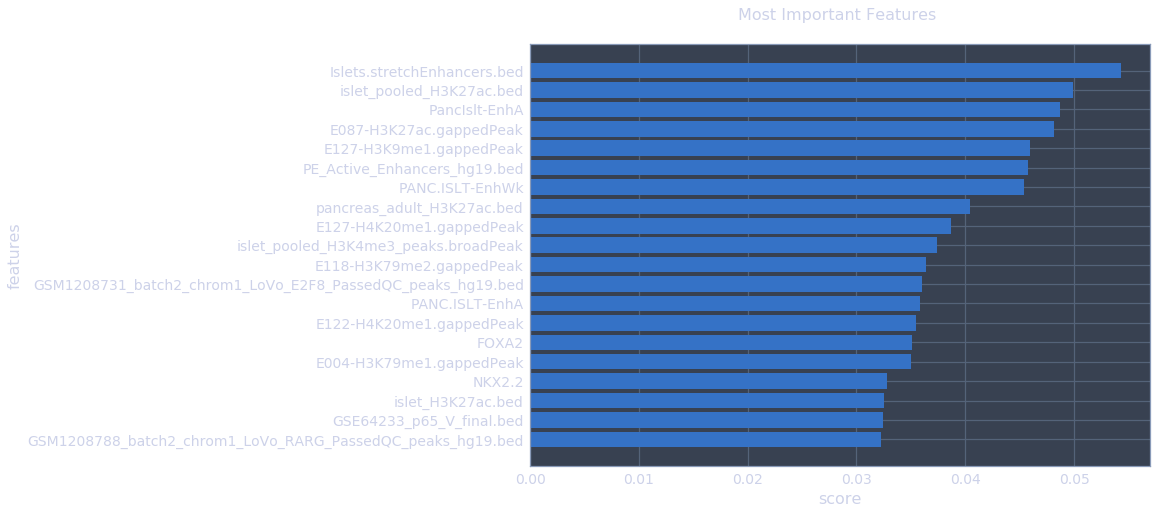

In [27]:
# Plot feature importance
coefs = rf_grid.best_estimator_.feature_importances_
feature_names = X_train.columns
ev.feat_importance(coefs, feature_names, 20, one_dim=True)

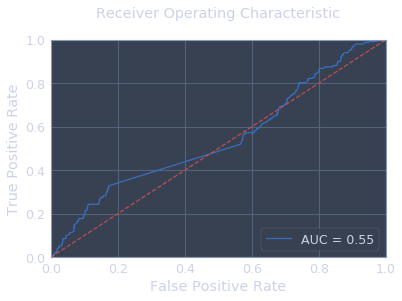

In [28]:
ev.plot_roc_curve(rf_grid, X_test, y_test)

### Gradient Boosted Trees

In [57]:
xgtrain = X_train.values
xgtrain_target = y_train.values
xgtest = X_test.values
xgtest_target = y_test.values

In [58]:
 # parameters to be tries in the grid search
cv_params = {'max_depth': [2, 3,5,7,10, 15, 20], 'min_child_weight': [1,2,3,4,5], 'scale_pos_weight':[2, 5, 7, 9]}   
#other parameters, fixed for the moment 
fix_params = {'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary:logistic','silent':True}   
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5)

In [59]:
# Trying to find best params for max depth and child weight
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

{'max_depth': 2, 'min_child_weight': 4, 'scale_pos_weight': 2}

In [60]:
best_depth = csv.best_params_['max_depth']
best_child_weight = csv.best_params_['min_child_weight']
best_pos_weight = csv.best_params_['scale_pos_weight']

In [61]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 150, 'objective': 'binary:logistic',
              'max_depth': best_depth, 'min_child_weight':best_child_weight, 'scale_pos_weight':best_pos_weight}

In [62]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.best_params_

{'max_delta_step': 0, 'subsample': 0.8}

In [63]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
fix_params['max_delta_step'] = csv.best_params_['max_delta_step']
fix_params['subsample'] = csv.best_params_['subsample']

In [64]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'roc_auc', cv = 5) 
csv.fit(xgtrain, xgtrain_target)
csv.cv_results_
csv.best_params_

{'learning_rate': 0.05}

In [65]:
fix_params['learning_rate'] = csv.best_params_['learning_rate']
params_final =  fix_params
params_final['eval_metric'] = 'auc'
print(params_final)

{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 2, 'min_child_weight': 4, 'scale_pos_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'eval_metric': 'auc'}


In [66]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)

xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[15:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

In [67]:
# Plot feature importance
# coefs = xgb_final.feature_importances_
# feature_names = X_train.columns
# ev.feat_importance(coefs, feature_names, 20, one_dim=True)

In [68]:
'''
Display ROC curve and AUC for a given model
'''
def plot_roc_curve(model, dmat_test, y, proba=True):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = model.predict(dmat_test)
    fpr, tpr, threshold = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic\n')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


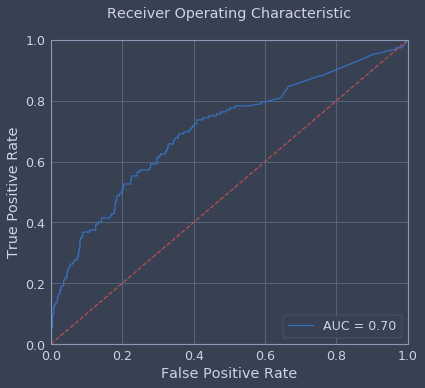

In [69]:
plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False)

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.25
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

In [72]:
def get_curves(X_train, y_train, X_val, y_val, pars):
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec


def gen_curves(X_train, y_train, X_val, y_val, pars):
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_train, y_train, X_val, y_val, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec

In [73]:
def plot_roc(X_train, y_train, X_val, y_val, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,7));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_train, y_train, X_val, y_val, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.5, 0.95])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.5, 1])
    plt.show()

{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 4, 'scale_pos_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'eval_metric': 'auc'}
{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 4, 'min_child_weight': 4, 'scale_pos_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'eval_metric': 'auc'}
{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 4, 'scale_pos_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'eval_metric': 'auc'}
{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 4, 'scale_pos_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'eval_metric': 'auc'}
{'learning_rate': 0.05, 'n_estimators': 150, 'objective': 'binary:logistic', 'max_depth': 10, 'min_child_weight': 4, 'scale_pos_weight': 2, 'max_delta_step': 0, 'subsample': 0.8, 'eval_metric': 'auc'}

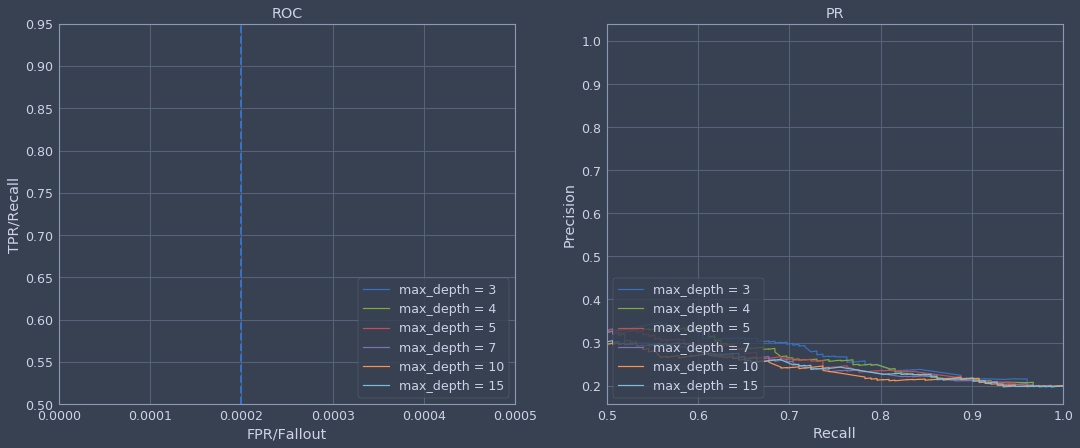

In [74]:
# par = params_final
# plot_roc(xgtrain, xgtrain_target, xgtest, xgtest_target, par, 'max_depth', [3,4,5,7,10,15])

In [75]:
par

{'learning_rate': 0.05,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'max_depth': 15,
 'min_child_weight': 4,
 'scale_pos_weight': 2,
 'max_delta_step': 0,
 'subsample': 0.8,
 'eval_metric': 'auc'}

In [76]:
par['max_depth'] = 3
par['learning_rate'] = 0.05
par['n_estimators'] = 100
par['scale_pos_weight'] = 2

[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

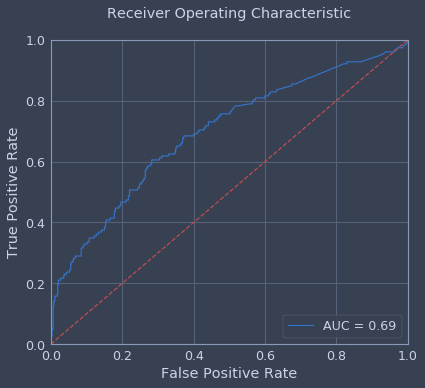

In [77]:
xgb_final = xgb.train(par, xgdmat_train, num_boost_round = 100)
plot_roc_curve(xgb_final, xgdmat_test, y_test, proba=False)

In [78]:
cnb_model = ComplementNB()
cnb_model.fit(X_train, y_train, sample_weight=None)

NameError: name 'ComplementNB' is not defined

In [ ]:
print("Training Dataset CNB", end=" ")
summarize_performance(cnb_model, X_train, y_train, proba=False)

In [ ]:
print("Training Dataset CNB", end=" ")
summarize_performance(cnb_model, X_test, y_test, proba=False)

In [ ]:
ev.plot_roc_curve(cnb_model, X_test, y_test)